<a href="https://colab.research.google.com/github/shanikairoshi/Communication-Efficient-DUQFL/blob/main/main_v2_1.3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %%capture
!pip install genomic-benchmarks
!pip install qiskit qiskit_machine_learning qiskit_algorithms qiskit-aer




  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 81.8 MB/s eta 0:00:00
  Created wheel for genomic-benchmarks: filename=genomic_benchmarks-1.0.0-py3-none-any.whl size=22550 sha256=cc2c5974f49d748a9e2855c82e713529ba1ce2b623f5ac5ff5078d756c45215e
  Stored in directory: /root/.cache/pip/wheels/9a/3a/9a/0f21797a390f81beeeb52e9ccc71e6d5e262786ecd01e046bf
Successfully built genomic-benchmarks
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.8/327.8 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys
from pathlib import Path
PROJ = Path.cwd() / "tduqfl_Project_AGG"
if str(PROJ) not in sys.path:
    sys.path.insert(0, str(PROJ))
import sys
sys.path.append('/content/drive/MyDrive/Teleportation/tduqfl_Project_AGG/tDuQFL_Project')
# ─── 5. Assemble filenames for each artifact ─────────────────────────────────
#drive_root = "/content/drive/MyDrive/Teleportation/tduqfl_Project_AGG/tDuQFL_Project/"

In [5]:
from common.imports import *
from configs.dataset_genome_iid import *     # swap to other configs as needed
from io_utils.naming import stamp_now, flags, build_param_str, make_filenames

start_str, date_str = stamp_now()
teleport_pl, noise_pl = flags(use_teleportation, use_noise)
param_str = build_param_str(num_clients, num_federated_layers, num_deep_unfolding_iterations,
                            initial_learning_rate, initial_perturbation)

best_client_csv_file, global_csv_file, local_csv_file, validation_csv_file = make_filenames(
    drive_root, dataset_name, split_type, date_str, teleport_pl, noise_pl, param_str
)
from io_utils.csv_logger import init_local_csv, init_best_csv, init_validation_csv

# Create folders + write headers
init_best_csv(best_client_csv_file)

local_headers = [
    "Federated Round", "Client Number", "Iteration",
    "Objective Function Value", "Training Accuracy", "Test Accuracy",
    "Learning Rate", "Perturbation"
]
init_local_csv(local_csv_file, local_headers)

init_validation_csv(validation_csv_file)

# Do NOT pre-init global_csv_file here because your save_accuracies_to_csv()
# already writes the header each time it runs (in 'w' mode).

/usr/local/lib/python3.12/dist-packages/genomic_benchmarks/utils/datasets.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Qiskit: 1.4.4
qiskit_aer available?: True


Load and Split data

In [6]:
from data.preprocess_genome import load_and_prepare_dataset
from data.splitters import split_dataset_for_epochs
from configs.base_config import (
    num_clients, num_epochs, samples_per_epoch, split_type,
    global_seed
)

np_train_data, np_test_data = load_and_prepare_dataset(word_size, global_seed)

# 2) Compute feasible epoch capacity and cap both epochs and rounds
N_train = len(np_train_data)
train_capacity = N_train // (num_clients * samples_per_epoch)
num_epochs_eff = max(1, min(num_epochs, train_capacity))

if train_capacity == 0:
    raise ValueError(
        f"Not enough training samples ({N_train}) for "
        f"{num_clients=} × {samples_per_epoch=} per epoch. "
        "Reduce samples_per_epoch or num_clients, or enable resampling."
    )

num_federated_layers_eff = min(num_federated_layers, num_epochs_eff)

# Build clients
if split_type.lower() == "iid":
    from data.splitters import split_dataset_for_epochs
    clients = split_dataset_for_epochs(
        num_clients=num_clients,
        num_epochs=num_epochs_eff,             # or num_epochs
        train_data=np_train_data,
        test_data=np_test_data,
        samples_per_epoch=samples_per_epoch,
    )
elif split_type.lower() in {"noniid", "non-iid", "non_iid"}:
    from data.noniid import make_non_iid_clients
    clients = make_non_iid_clients(
        train_data=np_train_data,
        test_data=np_test_data,
        num_clients=num_clients,
        num_epochs=num_epochs_eff,             # or num_epochs
        samples_per_epoch=samples_per_epoch,
        non_iid_ratio=0.8,                     # tune as needed
        quantity_variation=0.5,                # tune as needed
        seed=global_seed,
        plot=True
    )
else:
    raise ValueError(f"Unknown split_type: {split_type}")

'''
clients = split_dataset_for_epochs(
    num_clients=num_clients, num_epochs=num_epochs,
    train_data=np_train_data, test_data=np_test_data,
    samples_per_epoch=samples_per_epoch
)
'''
# validation/tables
test_sequences = np.array([d["sequence"] for d in np_test_data])
test_labels    = np.array([d["label"]    for d in np_test_data])
X_val, y_val   = test_sequences, test_labels

# derive num_features once
if clients and clients[0].data and clients[0].data[0]:
    num_features = clients[0].data[0][0]['sequence'].shape[0]
else:
    raise RuntimeError("Empty client data – check splitting indices.")


In [7]:
# Infer num_features from the first available sample in clients
def infer_num_features_from_clients(clients):
    for c in clients:
        for epoch_data in c.data:              # list of samples for that epoch
            if not epoch_data:
                continue
            sample = epoch_data[0]
            if "sequence" in sample:           # your Genome pipeline
                arr = np.asarray(sample["sequence"])
                return int(arr.size)
            if "features" in sample:           # some other pipelines
                arr = np.asarray(sample["features"])
                return int(arr.size)
            if "image" in sample:              # e.g., MNIST before flatten
                arr = np.asarray(sample["image"]).reshape(-1)
                return int(arr.size)
            # add any other key you use
    raise RuntimeError("Could not infer num_features: no samples found.")

num_features = infer_num_features_from_clients(clients)
print(f"[info] num_features = {num_features}")


[info] num_features = 5


run federated loop and plot

Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

[Round 0] Teleportation OFF | Aggregation=best
[round 0 | client 0] seed LR=0.1400000000 (prev=0.1400000000), seed PERT=0.1400000000 (prev=0.1400000000), gamma=1.00


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.487030 step=0.02795 g_raw=+0.013 g_sm=+0.002 acc=1 | LR→0.140280 PERT→0.140000 (scale=0.04)
[meta] cb#010 loss=0.481864 step=0.04636 g_raw=+0.018 g_sm=+0.006 acc=1 | LR→0.140561 PERT→0.140000 (scale=0.04)
[meta] cb#015 loss=0.478418 step=0.03597 g_raw=+0.013 g_sm=+0.008 acc=1 | LR→0.140843 PERT→0.140000 (scale=0.04)
[meta] cb#020 loss=0.473077 step=0.01103 g_raw=+0.005 g_sm=+0.010 acc=1 | LR→0.141125 PERT→0.140001 (scale=0.04)
[meta] cb#025 loss=0.469252 step=0.005033 g_raw=+0.001 g_sm=+0.011 acc=1 | LR→0.141408 PERT→0.140001 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1400000000, PERT_used=0.1400000000 → LR_next=0.1414079494, PERT_next=0.1400009168
[meta-summary] callbacks=25 g_raw_mean=+0.015 g_sm_mean=+0.007 acc_ratio=1.00 | LR 0.1400000000→0.1414079494 PERT 0.14000000

Training Progress:   2%|▏         | 1/50 [14:57<12:12:57, 897.50s/it]

[Round   0] acc_g=0.747 (μ=0.677, σ=0.080, FG=0.141) | t=881.512s, val=0.550 | TEL=FALSE
[Round 1] Teleportation OFF | Aggregation=best
[round 1 | client 0] seed LR=0.1471853538 (prev=0.1471853538), seed PERT=0.1400070394 (prev=0.1400070394), gamma=1.00


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.456573 step=0.071 g_raw=+0.023 g_sm=+0.003 acc=1 | LR→0.147480 PERT→0.140007 (scale=0.04)
[meta] cb#010 loss=0.452095 step=0.02911 g_raw=+0.008 g_sm=+0.006 acc=1 | LR→0.147775 PERT→0.140007 (scale=0.04)
[meta] cb#015 loss=0.450152 step=0.03699 g_raw=+0.013 g_sm=+0.007 acc=1 | LR→0.148072 PERT→0.140007 (scale=0.04)
[meta] cb#020 loss=0.448639 step=0.007459 g_raw=+0.005 g_sm=+0.008 acc=1 | LR→0.148368 PERT→0.140008 (scale=0.04)
[meta] cb#025 loss=0.445461 step=0.005189 g_raw=+0.005 g_sm=+0.008 acc=1 | LR→0.148665 PERT→0.140008 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1471853538, PERT_used=0.1400070394 → LR_next=0.1486654505, PERT_next=0.1400078486
[meta-summary] callbacks=25 g_raw_me

Training Progress:   4%|▍         | 2/50 [29:58<11:59:45, 899.69s/it]

[Round   1] acc_g=0.744 (μ=0.701, σ=0.094, FG=0.200) | t=885.154s, val=0.613 | TEL=FALSE
[Round 2] Teleportation OFF | Aggregation=best
[round 2 | client 0] seed LR=0.1547380765 (prev=0.1547380765), seed PERT=0.1400128016 (prev=0.1400128016), gamma=1.00


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.492569 step=0.03857 g_raw=+0.013 g_sm=+0.004 acc=1 | LR→0.155048 PERT→0.140013 (scale=0.04)
[meta] cb#010 loss=0.478301 step=0.05684 g_raw=+0.026 g_sm=+0.009 acc=1 | LR→0.155359 PERT→0.140013 (scale=0.04)
[meta] cb#015 loss=0.468771 step=0.01208 g_raw=+0.005 g_sm=+0.011 acc=1 | LR→0.155670 PERT→0.140013 (scale=0.04)
[meta] cb#020 loss=0.464761 step=0.03652 g_raw=+0.009 g_sm=+0.012 acc=1 | LR→0.155982 PERT→0.140014 (scale=0.04)
[meta] cb#025 loss=0.458134 step=0.03145 g_raw=+0.013 g_sm=+0.013 acc=1 | LR→0.156295 PERT→0.140014 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1547380765, PERT_used=0.1400128016 → LR_next=0.1562946108, PERT_next=0.1400140475
[meta-summary] callbacks=25 g_raw_me

Training Progress:   6%|▌         | 3/50 [45:10<11:49:09, 905.32s/it]

[Round   2] acc_g=0.871 (μ=0.764, σ=0.090, FG=0.178) | t=891.703s, val=0.559 | TEL=FALSE
[Round 3] Teleportation OFF | Aggregation=best
[round 3 | client 0] seed LR=0.1626816061 (prev=0.1626816061), seed PERT=0.1400213560 (prev=0.1400213560), gamma=1.00


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.485124 step=0.01861 g_raw=+0.012 g_sm=+0.005 acc=1 | LR→0.163007 PERT→0.140021 (scale=0.04)
[meta] cb#010 loss=0.475321 step=0.05899 g_raw=+0.016 g_sm=+0.009 acc=1 | LR→0.163334 PERT→0.140022 (scale=0.04)
[meta] cb#015 loss=0.468018 step=0.1044 g_raw=+0.031 g_sm=+0.011 acc=1 | LR→0.163661 PERT→0.140022 (scale=0.04)
[meta] cb#020 loss=0.462223 step=0.08114 g_raw=+0.024 g_sm=+0.013 acc=1 | LR→0.163989 PERT→0.140022 (scale=0.04)
[meta] cb#025 loss=0.456299 step=0.05596 g_raw=+0.016 g_sm=+0.015 acc=1 | LR→0.164318 PERT→0.140023 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1626816061, PERT_used=0.1400213560 → LR_next=0.1643181040, PERT_next=0.1400226518
[meta-summary] callbacks=25 g_raw_mea

Training Progress:   8%|▊         | 4/50 [1:00:14<11:33:38, 904.75s/it]

[Round   3] acc_g=0.769 (μ=0.630, σ=0.124, FG=0.280) | t=886.444s, val=0.556 | TEL=FALSE
[Round 4] Teleportation OFF | Aggregation=best
[round 4 | client 0] seed LR=0.1710337723 (prev=0.1710337723), seed PERT=0.1400306092 (prev=0.1400306092), gamma=1.00


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.522115 step=0.07528 g_raw=+0.022 g_sm=+0.003 acc=1 | LR→0.171376 PERT→0.140031 (scale=0.04)
[meta] cb#010 loss=0.502218 step=0.1024 g_raw=+0.038 g_sm=+0.011 acc=1 | LR→0.171720 PERT→0.140031 (scale=0.04)
[meta] cb#015 loss=0.490897 step=0.02022 g_raw=+0.006 g_sm=+0.014 acc=1 | LR→0.172064 PERT→0.140031 (scale=0.04)
[meta] cb#020 loss=0.485260 step=0.1006 g_raw=+0.032 g_sm=+0.015 acc=1 | LR→0.172409 PERT→0.140032 (scale=0.04)
[meta] cb#025 loss=0.471743 step=0.0574 g_raw=+0.016 g_sm=+0.017 acc=1 | LR→0.172755 PERT→0.140032 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1710337723, PERT_used=0.1400306092 → LR_next=0.1727545123, PERT_next=0.1400320861
[meta-summary] callbacks=25 g_raw_mean=

Training Progress:  10%|█         | 5/50 [1:15:24<11:20:00, 906.67s/it]

[Round   4] acc_g=0.854 (μ=0.727, σ=0.127, FG=0.270) | t=893.517s, val=0.538 | TEL=FALSE
[Round 5] Teleportation OFF | Aggregation=best
[round 5 | client 0] seed LR=0.1798156080 (prev=0.1798156080), seed PERT=0.1400405364 (prev=0.1400405364), gamma=1.00


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.471583 step=0.1193 g_raw=+0.034 g_sm=+0.004 acc=1 | LR→0.180176 PERT→0.140041 (scale=0.04)
[meta] cb#010 loss=0.465291 step=0.009308 g_raw=+0.003 g_sm=+0.007 acc=1 | LR→0.180537 PERT→0.140041 (scale=0.04)
[meta] cb#015 loss=0.460934 step=0.02928 g_raw=+0.007 g_sm=+0.009 acc=1 | LR→0.180898 PERT→0.140041 (scale=0.04)
[meta] cb#020 loss=0.455030 step=0.06036 g_raw=+0.014 g_sm=+0.011 acc=1 | LR→0.181261 PERT→0.140041 (scale=0.04)
[meta] cb#025 loss=0.448639 step=0.002453 g_raw=-0.001 g_sm=+0.012 acc=1 | LR→0.181624 PERT→0.140042 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1798156080, PERT_used=0.1400405364 → LR_next=0.1816241781, PERT_next=0.1400416106
[meta-summary] callbacks=25 g_raw_m

Training Progress:  12%|█▏        | 6/50 [1:30:19<11:02:01, 902.77s/it]

[Round   5] acc_g=0.800 (μ=0.730, σ=0.062, FG=0.140) | t=875.547s, val=0.535 | TEL=FALSE
[Round 6] Teleportation OFF | Aggregation=best
[round 6 | client 0] seed LR=0.1890456903 (prev=0.1890456903), seed PERT=0.1400484919 (prev=0.1400484919), gamma=1.00


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.488368 step=0.02978 g_raw=+0.007 g_sm=+0.001 acc=1 | LR→0.189424 PERT→0.140049 (scale=0.04)
[meta] cb#010 loss=0.484630 step=0.01314 g_raw=+0.007 g_sm=+0.004 acc=1 | LR→0.189804 PERT→0.140049 (scale=0.04)
[meta] cb#015 loss=0.484362 step=0.008889 g_raw=+0.002 g_sm=+0.004 acc=1 | LR→0.190184 PERT→0.140049 (scale=0.04)
[meta] cb#020 loss=0.481045 step=0.07364 g_raw=+0.020 g_sm=+0.006 acc=1 | LR→0.190565 PERT→0.140049 (scale=0.04)
[meta] cb#025 loss=0.476592 step=0.09585 g_raw=+0.031 g_sm=+0.007 acc=1 | LR→0.190946 PERT→0.140049 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1890456903, PERT_used=0.1400484919 → LR_next=0.1909463570, PERT_next=0.1400490243
[meta-summary] callbacks=25 g_raw_m

Training Progress:  14%|█▍        | 7/50 [1:45:16<10:45:39, 900.92s/it]

[Round   6] acc_g=0.811 (μ=0.787, σ=0.050, FG=0.101) | t=880.489s, val=0.520 | TEL=FALSE
[Round 7] Teleportation OFF | Aggregation=best
[round 7 | client 0] seed LR=0.1987470842 (prev=0.1987470842), seed PERT=0.1400547031 (prev=0.1400547031), gamma=1.00


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.536581 step=0.03813 g_raw=+0.012 g_sm=+0.002 acc=1 | LR→0.199145 PERT→0.140055 (scale=0.04)
[meta] cb#010 loss=0.531643 step=0.08643 g_raw=+0.022 g_sm=+0.005 acc=1 | LR→0.199544 PERT→0.140055 (scale=0.04)
[meta] cb#015 loss=0.528383 step=0.001929 g_raw=+0.002 g_sm=+0.006 acc=1 | LR→0.199944 PERT→0.140055 (scale=0.04)
[meta] cb#020 loss=0.513895 step=0.0148 g_raw=+0.001 g_sm=+0.011 acc=1 | LR→0.200344 PERT→0.140055 (scale=0.04)
[meta] cb#025 loss=0.509584 step=0.03217 g_raw=+0.009 g_sm=+0.011 acc=1 | LR→0.200746 PERT→0.140056 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1987470842, PERT_used=0.1400547031 → LR_next=0.2007457886, PERT_next=0.1400555842
[meta-summary] callbacks=25 g_raw_me

Training Progress:  16%|█▌        | 8/50 [2:00:16<10:30:22, 900.54s/it]

[Round   7] acc_g=0.792 (μ=0.697, σ=0.044, FG=0.092) | t=883.789s, val=0.527 | TEL=FALSE
[Round 8] Teleportation OFF | Aggregation=best
[round 8 | client 0] seed LR=0.2089480109 (prev=0.2089480109), seed PERT=0.1400620403 (prev=0.1400620403), gamma=1.00


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.526813 step=0.206 g_raw=+0.057 g_sm=+0.005 acc=1 | LR→0.209366 PERT→0.140062 (scale=0.04)
[meta] cb#010 loss=0.515369 step=0.04261 g_raw=+0.010 g_sm=+0.008 acc=1 | LR→0.209786 PERT→0.140062 (scale=0.04)
[meta] cb#015 loss=0.494112 step=0.089 g_raw=+0.021 g_sm=+0.013 acc=1 | LR→0.210206 PERT→0.140063 (scale=0.04)
[meta] cb#020 loss=0.485954 step=0.1158 g_raw=+0.027 g_sm=+0.014 acc=1 | LR→0.210628 PERT→0.140063 (scale=0.04)
[meta] cb#025 loss=0.483559 step=0.01939 g_raw=+0.006 g_sm=+0.013 acc=1 | LR→0.211050 PERT→0.140063 (scale=0.04)
[client 0 | unfold 1] LR_used=0.2089480109, PERT_used=0.1400620403 → LR_next=0.2110500060, PERT_next=0.1400633892
[meta-summary] callbacks=25 g_raw_mean=+0

Training Progress:  18%|█▊        | 9/50 [2:15:11<10:14:06, 898.68s/it]

[Round   8] acc_g=0.773 (μ=0.679, σ=0.026, FG=0.051) | t=873.561s, val=0.529 | TEL=FALSE
[Round 9] Teleportation OFF | Aggregation=best
[round 9 | client 0] seed LR=0.2196739583 (prev=0.2196739583), seed PERT=0.1400703000 (prev=0.1400703000), gamma=1.00


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.512122 step=0.1136 g_raw=+0.030 g_sm=+0.004 acc=1 | LR→0.220114 PERT→0.140070 (scale=0.04)
[meta] cb#010 loss=0.495458 step=0.08394 g_raw=+0.022 g_sm=+0.009 acc=1 | LR→0.220555 PERT→0.140071 (scale=0.04)
[meta] cb#015 loss=0.484709 step=0.06592 g_raw=+0.014 g_sm=+0.011 acc=1 | LR→0.220997 PERT→0.140071 (scale=0.04)
[meta] cb#020 loss=0.475572 step=0.03656 g_raw=+0.013 g_sm=+0.013 acc=1 | LR→0.221440 PERT→0.140071 (scale=0.04)
[meta] cb#025 loss=0.465012 step=0.01562 g_raw=+0.005 g_sm=+0.014 acc=1 | LR→0.221884 PERT→0.140072 (scale=0.04)
[client 0 | unfold 1] LR_used=0.2196739583, PERT_used=0.1400703000 → LR_next=0.2218837349, PERT_next=0.1400715731
[meta-summary] callbacks=25 g_raw_mea

Training Progress: 100%|██████████| 50/50 [2:31:11<00:00, 181.43s/it]   

[Round   9] acc_g=0.754 (μ=0.655, σ=0.093, FG=0.205) | t=943.841s, val=0.549 | TEL=FALSE
[Round 10] Teleportation OFF | Aggregation=best
[Round 10] No eligible clients; skipping global update.
[Round 11] Teleportation OFF | Aggregation=best
[Round 11] No eligible clients; skipping global update.
[Round 12] Teleportation OFF | Aggregation=best
[Round 12] No eligible clients; skipping global update.
[Round 13] Teleportation OFF | Aggregation=best
[Round 13] No eligible clients; skipping global update.
[Round 14] Teleportation OFF | Aggregation=best
[Round 14] No eligible clients; skipping global update.
[Round 15] Teleportation OFF | Aggregation=best
[Round 15] No eligible clients; skipping global update.
[Round 16] Teleportation OFF | Aggregation=best
[Round 16] No eligible clients; skipping global update.
[Round 17] Teleportation OFF | Aggregation=best
[Round 17] No eligible clients; skipping global update.
[Round 18] Teleportation OFF | Aggregation=best
[Round 18] No eligible clients;

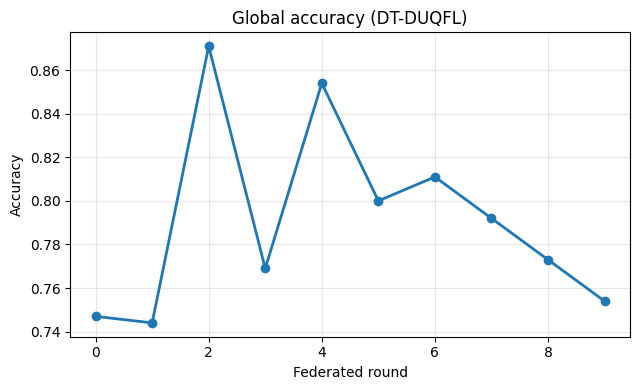

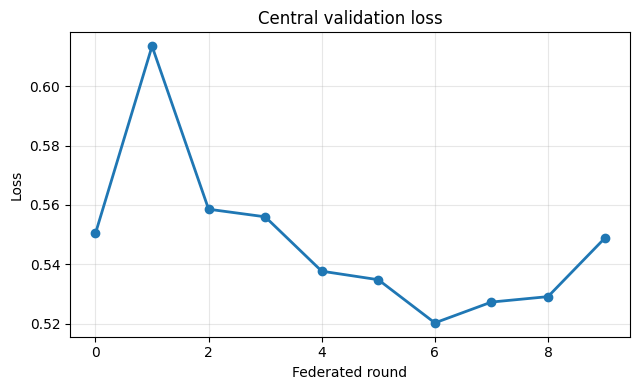

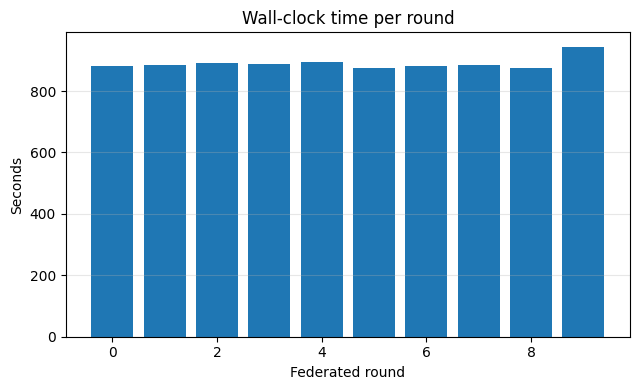

In [8]:
from training.loop import run_federated_training
from configs.base_config import use_teleportation as CFG_TEL, noise_preset, shots_used,aggregation
from training.metrics import metrics_init, metrics_log_round, metrics_finalize, compute_auc,metrics_summarize
from viz.plots import plot_accuracy_curve, plot_val_loss, plot_time_per_round, plot_fidelity_vs_delta_acc, plot_beta_hist, plot_client_fairness_last_round
# Initialize metrics store once
metrics_store = metrics_init(
    log_path=os.path.join(drive_root, "teleport_metrics_Perturb_shrink.csv")
)

#new
from ml import optimizers as mlopt
from configs.base_config import drive_root
import os

mlopt.meta_trace_enable(
    path=os.path.join(drive_root, "meta_trace.csv"),  # or None to skip CSV
    every=5                                           # print every 5 callbacks
)

###########
global_acc, clients_train, clients_test, round_times, val_losses, info_last = run_federated_training(
    clients=clients,
    num_federated_layers=num_federated_layers,
    num_deep_unfolding_iterations=num_deep_unfolding_iterations,
    initial_learning_rate=initial_learning_rate,
    initial_perturbation=initial_perturbation,
    num_features=num_features,
    best_client_csv_file=best_client_csv_file,
    global_csv_file=global_csv_file,
    local_csv_file=local_csv_file,
    validation_csv_file=validation_csv_file,
    test_sequences=test_sequences,
    test_labels=test_labels,
    X_val=X_val,
    y_val=y_val,
    use_teleportation=CFG_TEL,          # ← important
    noise_preset=noise_preset,
    shots_used=shots_used,
    metrics=metrics_store,   # <-- pass it in
    aggregation=aggregation           # <--- switch here
)

rows_np = metrics_finalize(metrics_store)   # if you need the in-memory array
#summary = metrics_summarize(metrics_store)  # prints a concise summary, returns a dict

# quick visuals
rounds = list(range(len(global_acc)))
plot_accuracy_curve(rounds, global_acc, label="Global accuracy (DT-DUQFL)")
plot_val_loss(rounds, val_losses, label="Central validation loss")
plot_time_per_round(rounds, round_times)

if info_last is not None:
    # this uses "last" round's info; in your logger you kept per-round arrays; adapt if needed
    pass
